<a href="https://colab.research.google.com/github/AlexNoonan-Syracuse/Lab6/blob/main/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
from google.colab import files
import io
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# download from http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv
uploaded = files.upload()


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving Zip_Zhvi_SingleFamilyResidence.csv to Zip_Zhvi_SingleFamilyResidence.csv


In [ ]:


df1 = pd.read_csv(io.StringIO(uploaded['Zip_Zhvi_SingleFamilyResidence.csv'].decode('utf-8')))

# data exploration
print(df1.isna().sum())
print(df1.columns)
df1['RegionName'] = df1['RegionName'].astype(str)
print(df1.dtypes)
#print(df1.describe)
print(df1.head())

In [ ]:
# time series of Hot Springs, Little Rock, Fayetteville, Searcy 
# Present all values from 1997 to present 
# Average at the metro area level

# reshape dataframe on
metro_areas = ['Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy']

dfAr =  df1[df1['State']=="AR"]
dfAr = dfAr[dfAr['City'].isin(metro_areas)]

# removing 1996 columns
dfAr = dfAr[dfAr.columns.drop(list(dfAr.filter(regex='1996-')))]
dfAr.reset_index(inplace=True)
dfAr = dfAr.drop(columns=['index','RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName','State', 'City', 'CountyName'])

dfAr['Metro'] = dfAr['Metro'].str.replace('Fayetteville-Springdale-Rogers', 'Fayetteville')
dfAr['Metro'] = dfAr['Metro'].str.replace('Little Rock-North Little Rock-Conway', 'Little Rock')
print(dfAr.head())

# aggregating averages across the metros and dates
dfAr_avg = dfAr.groupby('Metro').mean()

# pivoting on dates

# list of date columns
dateCols = list(dfAr_avg.filter(regex='-'))
list(dfAr_avg.index)

In [ ]:
# reshaping dfAr index = columnames, value = dates, column = metro

dfArFinal = pd.melt(dfAr, id_vars=dateCols, value_vars='Metro' )
dfArFinal = dfArFinal.groupby('value').mean()
dfArFinal.reset_index(inplace=True)
dfArFinal.rename(columns={'value':'Metro'}, inplace=True)

dfArFinal = pd.melt(dfArFinal, id_vars='Metro', value_vars=dateCols )
dfArFinal.rename(columns={'value':'Avg', 'variable':'Date'}, inplace=True)
dfArFinal['Date'] = pd.to_datetime(dfArFinal['Date'], infer_datetime_format=True)
dfArFinal.set_index('Date', inplace=True)
print(dfArFinal)


In [6]:
def return_calc(df, metro):
    # takes in df and retro an calculates return
    df1 = df.loc[df['Metro']==metro]
    return round((df1.iloc[-1,1] - df1.iloc[0,1])/df1.iloc[0,1]*100,2)
    

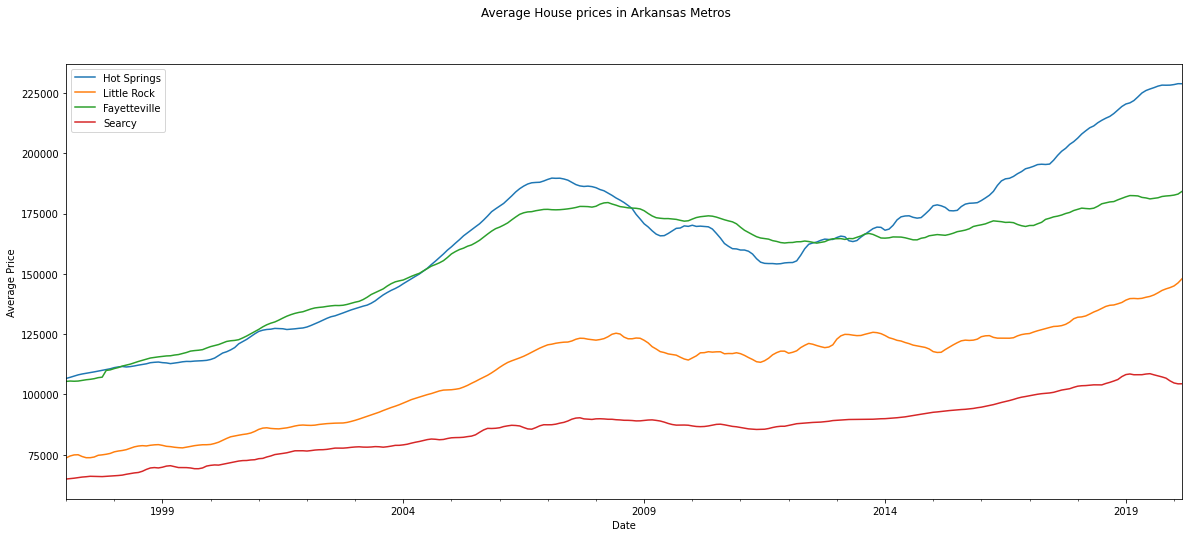

,Metro,Total Return%
0,Fayetteville,114.580000
1,Hot Springs,100.850000
2,Little Rock,74.750000
3,Searcy,60.820000


In [11]:
# time series plots of Avg price over time

fig, ax = plt.subplots()
fig.suptitle('Average House prices in Arkansas Metros')
fig.set_figheight(8)
fig.set_figwidth(20)

# Additional customizations
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
dfArFinal.groupby('Metro').plot( ax=ax, label='Metro')
plt.legend(metro_areas)
#dfArFinal.plot(ax=ax,label=dfArFinal['Metro'])
plt.show()

# return summary
summary_table = []
for i in range(len(metro_areas)):
  summary_table.append(return_calc(dfArFinal, metro_areas[i])) 

summary_table=pd.DataFrame(zip(metro_areas,summary_table),columns=["Metro",'Total Return%'])
summary_table.sort_values('Total Return%', ascending=False, ignore_index=True).style


In [18]:
# need to read in data to determine which metros to use 
# pick top 3 by pct change 

incomeGrowth = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/Lab6/main/Incomepermetro.csv",  error_bad_lines=False)
#print(incomeGrowth.dtypes)
incomeGrowth.sort_values('2019 PCt Change Rank', ascending=True, inplace=True)

topFiveIncome = incomeGrowth.nsmallest(5, '2019 PCt Change Rank')
topFiveIncome = topFiveIncome['Metropolitan Statistical Areas2'].str.split(',', expand=True)
topFiveIncome.rename(columns={0:'Metro', 1:'State'}, inplace=True)
topFiveIncome.reset_index(inplace=True)
topFiveIncome.drop(columns='index', inplace=True)
#topFiveIncome = list(topFiveIncome['Metropolitan Statistical Areas2'])
topFiveIncome['Metro'] = topFiveIncome['Metro'].str.replace('Visalia', 'Visalia-Porterville')

print(topFiveIncome)
modelingdf = pd.merge(topFiveIncome, df1, how='inner', on='Metro')
print(modelingdf)
print(modelingdf.columns)
metroList = modelingdf['Metro'].unique()
modelingdateCols = list(modelingdf.filter(regex='-'))

for dates in modelingdateCols:
    colname = str(dates) + 'Rollmean3'
    #print(colname)
    modelingdf[colname]  = modelingdf[dates].rolling( 3,center=True,min_periods=1).mean()
    modelingdf[dates] = modelingdf[colname]
dropCols = list(modelingdf.filter(regex='Rollmean3'))
#drop orignal date columns
modelingdf.drop(columns=dropCols, inplace=True) 

#rename moving average columns

#modelingdf = modelingdf.rename(columns=lambda x: x[:-8] if 'Rollmean3' in x  else x)
print(modelingdf.columns)
print(metroList)

                 Metro State
0            El Centro    CA
1                Chico    CA
2     Hanford-Corcoran    CA
3  Visalia-Porterville    CA
4          Panama City    FL
          Metro State_x  RegionID  ...  2020-01-31 2020-02-29 2020-03-31
0     El Centro      CA     96750  ...    243740.0   245573.0   247389.0
1     El Centro      CA     96740  ...    249671.0   252738.0   255387.0
2     El Centro      CA     96738  ...    240275.0   242748.0   245117.0
3     El Centro      CA     96756  ...    270918.0   273297.0   275827.0
4     El Centro      CA     96775  ...    163163.0   164654.0   166351.0
..          ...     ...       ...  ...         ...        ...        ...
80  Panama City      FL     72021  ...     88657.0    89210.0    89762.0
81  Panama City      FL     72022  ...    168822.0   169796.0   170759.0
82  Panama City      FL     72017  ...    952767.0   950561.0   950677.0
83  Panama City      FL     71999  ...     99937.0   101884.0   103785.0
84  Panama City      FL

                          Metro         Median
Date                                          
1996-01-31     Hanford-Corcoran   95645.000000
1996-01-31          Panama City   97946.000000
1996-01-31  Visalia-Porterville   84261.000000
1996-02-29            El Centro   43697.000000
1996-02-29     Hanford-Corcoran   95496.000000
...                         ...            ...
2020-03-31                Chico  249438.333333
2020-03-31            El Centro  223782.333333
2020-03-31     Hanford-Corcoran  178574.000000
2020-03-31          Panama City  225755.833333
2020-03-31  Visalia-Porterville  212304.000000

[1442 rows x 2 columns]


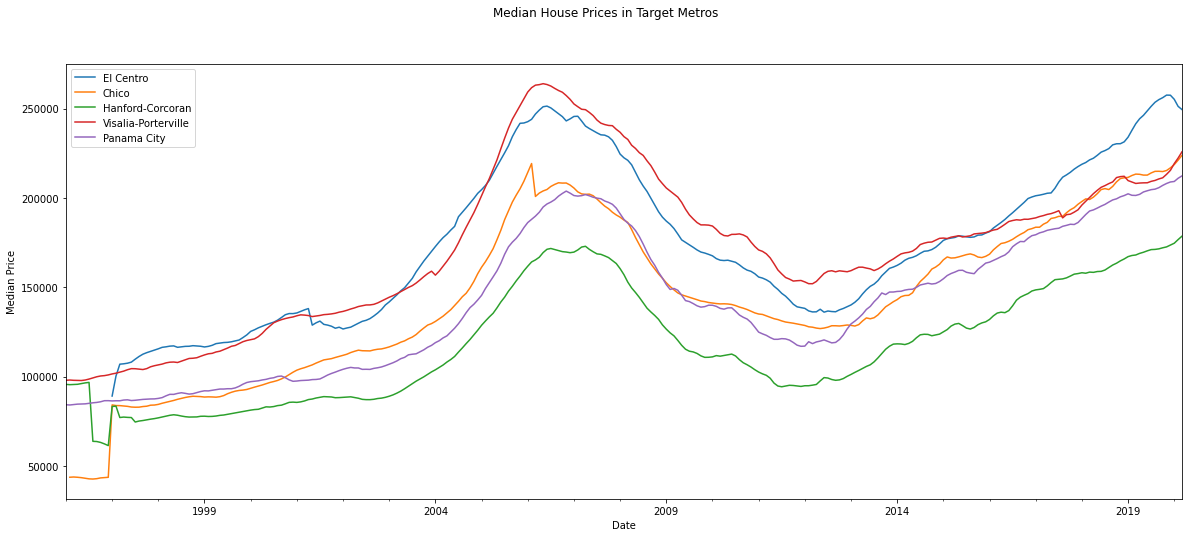

,Metro,Total Return%
0,El Centro,412.120000
1,Chico,179.870000
2,Visalia-Porterville,151.960000
3,Panama City,130.490000
4,Hanford-Corcoran,86.710000


In [19]:
# transforming modeldf so time series analysis for the plots
# reshaping dfAr index = columnames, value = dates, column = metro

modelingdfplot = pd.melt(modelingdf, id_vars=modelingdateCols, value_vars='Metro' )
modelingdfplot = modelingdfplot.groupby('value').median()
modelingdfplot.reset_index(inplace=True)
modelingdfplot.rename(columns={'value':'Metro'}, inplace=True)

modelingdfplot = pd.melt(modelingdfplot, id_vars='Metro', value_vars=modelingdateCols )
modelingdfplot.rename(columns={'value':'Median', 'variable':'Date'}, inplace=True)

modelingdfplot['Date'] = pd.to_datetime(modelingdfplot['Date'], infer_datetime_format=True)
modelingdfplot.set_index('Date', inplace=True)
modelingdfplot.dropna(inplace=True)
print(modelingdfplot)
# time series plots of Avg price over time

fig, ax = plt.subplots()
fig.suptitle('Median House Prices in Target Metros')
fig.set_figheight(8)
fig.set_figwidth(20)

# Additional customizations
ax.set_xlabel('Date')
ax.set_ylabel('Median Price')
modelingdfplot.groupby('Metro').plot( ax=ax, label='Metro')
plt.legend(metroList)
#dfArFinal.plot(ax=ax,label=dfArFinal['Metro'])
plt.show()

# return summary
returnSummary_table = []
for i in range(len(metroList)):
  returnSummary_table.append(return_calc(modelingdfplot, metroList[i])) 

returnSummary_table=pd.DataFrame(zip(metroList,returnSummary_table),columns=["Metro",'Total Return%'])
returnSummary_table.sort_values('Total Return%', ascending=False, ignore_index=True).style


In [20]:
# melting the full dataframe to create forecast of median house price per zip code from 2018 (1997-2017) as training set

#print(*df1.columns, sep = "\n")
# region name == zipcode
print(modelingdf.head())
# dropping columns 
modelingdf = modelingdf[modelingdf.columns.drop(list(modelingdf.filter(regex='1996-')))]
modelingdf.reset_index(inplace=True)
modelingdf = modelingdf.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'City', 'CountyName'])

mainDateCols = list(modelingdf.filter(regex='-'))
modelingdf = pd.melt(modelingdf, id_vars=mainDateCols, value_vars='RegionName', value_name='ZipCode' )
modelingdf = modelingdf.groupby('ZipCode').median()

modelingdf.reset_index(inplace=True)
modelingdf = pd.melt(modelingdf, id_vars='ZipCode', value_vars=mainDateCols , var_name='Date', value_name='Median_Home_Value')
modelingdf = pd.pivot_table(data=modelingdf,
    index='Date',
    columns='ZipCode',
   values = 'Median_Home_Value'
    ).reset_index()
modelingdf['Date'] = pd.to_datetime(modelingdf['Date'], infer_datetime_format=True)
modelingdf.set_index('Date', inplace=True)
modelingdf.head()



       Metro State_x  RegionID  ...     2020-01-31     2020-02-29     2020-03-31
0  El Centro      CA     96750  ...  246705.500000  249155.500000  251388.000000
1  El Centro      CA     96740  ...  244562.000000  247019.666667  249297.666667
2  El Centro      CA     96738  ...  253621.333333  256261.000000  258777.000000
3  El Centro      CA     96756  ...  224785.333333  226899.666667  229098.333333
4  El Centro      CA     96775  ...  218637.333333  221112.000000  223782.333333

[5 rows x 301 columns]


ZipCode,32401,32404,32405,32407,32408,32409,32413,32438,32444,32449,32456,32461,32465,32466,92227,92231,92233,92243,92249,92250,92251,92273,92274,92275,92281,93201,93202,93204,93207,93212,93218,93219,93221,93223,93227,93230,93235,93239,93244,93245,...,93265,93266,93267,93270,93271,93272,93274,93277,93282,93286,93291,93292,93603,93615,93618,93647,93666,93670,95914,95916,95917,95925,95926,95928,95930,95938,95941,95942,95948,95954,95958,95965,95966,95968,95969,95972,95973,95974,95978,96092
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997-01-31,97302.666667,109493.5,116339.000000,101502.666667,104656.666667,98294.000000,93840.000000,440163.0,94767.333333,NaN,89653.0,259952.0,87743.0,259952.0,89608.333333,84172.333333,107017.0,81882.5,100316.0,81432.333333,76477.000000,NaN,78098.000000,124706.0,NaN,NaN,83264.0,72060.5,64423.0,60857.0,64423.0,91155.666667,89062.000000,78211.000000,43375.0,104700.0,66185.666667,97871.0,64423.0,82778.500000,...,88347.000000,83264.0,90627.666667,72897.5,72111.333333,47984.666667,91122.5,106236.000000,88135.0,86397.333333,116693.000000,111012.333333,NaN,81855.5,100654.333333,88381.666667,NaN,NaN,NaN,89127.0,89127.0,NaN,129005.5,129005.500000,NaN,83875.000000,NaN,NaN,90245.500000,82660.666667,104700.0,82053.500000,67491.000000,89127.000000,NaN,NaN,133305.000000,NaN,NaN,NaN
1997-02-28,97734.000000,110118.5,116924.333333,101922.000000,105134.000000,98336.666667,94185.000000,443694.0,95163.666667,NaN,89373.5,261880.5,87561.5,261880.5,89096.333333,83803.000000,107536.0,81614.5,100254.5,81486.333333,76342.333333,NaN,77940.000000,124142.0,NaN,NaN,83489.0,72017.5,65116.0,82706.5,65116.0,91015.333333,89218.666667,78146.333333,43128.0,104572.0,66146.000000,97981.0,65116.0,89896.666667,...,88152.333333,83489.0,90395.333333,72660.5,72008.666667,48095.333333,91205.0,106270.666667,88603.0,86488.666667,116735.333333,111084.666667,NaN,81591.0,100728.333333,88498.333333,NaN,NaN,NaN,96376.0,72833.0,NaN,128788.0,134262.333333,NaN,111110.666667,NaN,56411.000000,109144.000000,83277.666667,104277.0,79934.333333,95805.666667,72833.000000,124445.0,NaN,117685.666667,NaN,NaN,NaN
1997-03-31,98305.666667,110651.5,117521.333333,102512.333333,105510.666667,98547.333333,94585.666667,447911.0,95496.666667,NaN,89410.5,263736.0,87027.5,263736.0,89006.000000,83772.666667,107626.0,81551.0,100359.5,81493.666667,76457.000000,NaN,78082.666667,123929.0,NaN,NaN,69708.5,71718.0,64889.0,82385.5,64889.0,90724.333333,89093.666667,78140.000000,43266.0,104164.0,66049.333333,77119.5,64889.0,89564.000000,...,87855.333333,69708.5,89811.000000,72199.0,71822.000000,48247.000000,91081.5,106011.333333,89216.0,86481.666667,116496.000000,110898.333333,NaN,81252.0,100593.666667,88427.666667,NaN,NaN,112482.0,97505.5,73931.5,NaN,128794.5,134147.000000,NaN,112001.333333,121443.0,94128.333333,110009.666667,84329.333333,103921.0,80797.333333,96216.666667,83794.666667,125156.5,NaN,117869.000000,NaN,NaN,NaN
1997-04-30,98663.666667,111246.5,117797.000000,103069.333333,105904.666667,99039.333333,94810.333333,454506.0,95846.000000,NaN,89932.5,266868.5,86961.0,266868.5,88586.666667,83560.666667,107919.0,81244.0,100658.0,81756.333333,76644.666667,NaN,78379.000000,123366.0,NaN,NaN,69251.5,71096.5,64403.0,82223.0,64403.0,90228.000000,89222.333333,78534.333333,43325.0,103713.0,66163.666667,77364.0,64403.0,89230.333333,...,87491.666667,69251.5,89148.000000,72268.5,71717.666667,48596.000000,91250.5,106092.000000,90029.0,86891.000000,116707.000000,111126.333333,NaN,80916.5,100756.000000,88759.666667,NaN,NaN,112569.0,98881.5,75377.0,NaN,128721.5,134176.333333,NaN,112848.333333,120748.0,94533.333333,111096.666667,85928.000000,103245.0,81788.333333,96745.000000,85048.000000,125566.5,NaN,118052.000000,NaN,NaN,NaN
1997-05-31,99309.333333,112387.5,118323.333333,103869.333333,106816.000000,99741.666667,95330.666667,457713.0,96632.666667,NaN,90711.5,268480.0,87236.5,268480.0,88285.000000,83361.666667,108257.0,80848.0,101301.5,82223.000000,7688

In [175]:
def Arima_modeling(df, columnName):
  # Arima Model testing and fitting for Zip Code List
  subsetdf = df[[columnName]]
  # subsetting from 1997-2017
  traindf =subsetdf.loc['1997-01-31':'2017-12-31']
  testdf = subsetdf.loc['2018-01-31':]


  # create a differenced series
  traindf['firstDiff'] = traindf[columnName].diff(periods=1)
  traindf['log'] = np.log(traindf[columnName])

  # adf test
  traindf = traindf.replace([np.inf, -np.inf], np.nan).dropna()
  result1 = adfuller(traindf['firstDiff'])
  result2 = adfuller(traindf['log'])
  

  if result1[1] < 0.05:
    #first diff model
    
    print('First difference')
    print('ADF Statistic: %f' % result1[0])
    print('p-value: %f' % result1[1])    
    traindf['firstDiff'].plot()
    plt.show()
    parameters = []
    for pindex in range(3):
        for qindex in range(3):
          p = pindex + 1 
          q = qindex + 1
          try:
            Model1 = ARIMA(traindf[columnName], order = (p,1,q)).fit()
          except ValueError:
            pass
          #print('AR:', p , 'MA:', q, 'AIC:', Model1.aic)
          # need a dictionary to save this p,q, aic
          param = {'AR': p, 'MA': q, 'AIC':Model1.aic} 
          parameters.append(param)
    # finding best parameters
    modelparams = pd.DataFrame(parameters)
    bestparams = modelparams[modelparams['AIC'] == modelparams['AIC'].min()]
    # fitting best model
    Fitted_model = ARIMA(traindf[columnName],
                         order = (int(bestparams.iloc[0]['AR'])
                         ,1
                         ,int(bestparams.iloc[0]['MA']))).fit()

    # returning model and test df
    return Fitted_model, testdf

  elif result2[1] < 0.05:
    # log model
    print('Log')
    print('ADF Statistic: %f' % result2[0])
    print('p-value: %f' % result2[1])
    traindf['log'].plot()
    plt.show()
    parameters = []
    for pindex in range(3):
        for qindex in range(3):
          p = pindex + 1 
          q = qindex + 1
          try:
            Model1 = ARIMA(traindf['log'], order = (p,1,q)).fit()
          except ValueError:
            pass  
          # need a dictionary to save this p,q, aic
          #print('AR:', p , 'MA:', q, 'AIC:', Model1.aic)
          param = {'AR': p, 'MA': q, 'AIC':Model1.aic} 
          parameters.append(param)

    # finding best parameters
    modelparams = pd.DataFrame(parameters)
    bestparams = modelparams[modelparams['AIC'] == modelparams['AIC'].min()]
    # fitting best model
    Fitted_model = ARIMA(traindf['log'],
                         order = (int(bestparams.iloc[0]['AR'])
                         ,1
                         ,int(bestparams.iloc[0]['MA']))).fit()
  # doing log calculation on test df
    testdf['log']  = np.log(testdf[columnName])
    traindf = traindf.replace([np.inf, -np.inf], np.nan).dropna()
    testdf[columnName] = testdf['log']
    return Fitted_model, testdf

  else:
    return print('Series is not stable!')


  

In [186]:
def Arima_forecast(model, testdf, zipcode):
  # forecasting
  predictions = list()

  # walk-forward validation
  predictions = model.forecast(steps=len(testdf))[0]
  predictionsdf = pd.DataFrame({'Date':testdf.index,'Predictions': predictions })
  predictionsdf.set_index('Date', inplace=True)

  # evaluate forecasts
  rmse = sqrt(mean_squared_error(testdf[zipcode], predictions))
  
  #returnval = round((predictionsdf.iloc[-1,0] - predictionsdf.iloc[0,0])/predictionsdf.iloc[0,0]*100,2)
  #print('Test RMSE: %.3f' % rmse)

  returnval = round((predictionsdf.iloc[-1,0] - predictionsdf.iloc[0,0])/predictionsdf.iloc[0,0]*100,2)

    # plot forecasts against actual outcomes
  plt.title('Forecast for '+ zipcode)
  plt.plot(testdf[zipcode])
  plt.plot(predictionsdf, color='red')
  plt.show()
  return rmse, returnval


-------------------------------------------------------------
Zipcode: 32401
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 32404
First difference
ADF Statistic: -3.117328
p-value: 0.025297


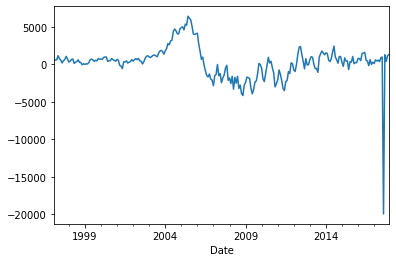

                             ARIMA Model Results                              
Dep. Variable:                D.32404   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2204.358
Method:                       css-mle   S.D. of innovations           1630.494
Date:                Sun, 22 Aug 2021   AIC                           4416.717
Time:                        17:55:38   BIC                           4430.802
Sample:                    03-31-1997   HQIC                          4422.386
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           268.5936    659.659      0.407      0.684   -1024.314    1561.501
ar.L1.D.32404     0.9509      0.023     40.815      0.000       0.905       0.997
ma.L1.D.32404    -0.6648      0.057    -

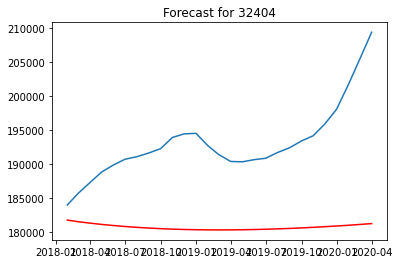

RSME: 13421.758884189005
Projected Return: -0.28%
-------------------------------------------------------------
Zipcode: 32405
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 32407
Log
ADF Statistic: -2.947589
p-value: 0.040087


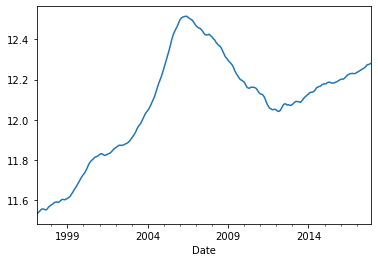

                             ARIMA Model Results                              
Dep. Variable:                  D.log   No. Observations:                  250
Model:                 ARIMA(1, 1, 3)   Log Likelihood                1112.394
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sun, 22 Aug 2021   AIC                          -2212.787
Time:                        17:55:44   BIC                          -2191.658
Sample:                    03-31-1997   HQIC                         -2204.283
                         - 12-31-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0033      0.003      1.029      0.304      -0.003       0.010
ar.L1.D.log     0.9652      0.018     53.172      0.000       0.930       1.001
ma.L1.D.log     0.2382      0.044      5.405    

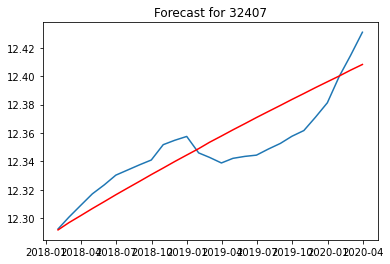

RSME: 0.01690177311505849
Projected Return: 0.95%
-------------------------------------------------------------
Zipcode: 32408
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 32409
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 32413
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 32438
First difference
ADF Statistic: -16.234133
p-value: 0.000000


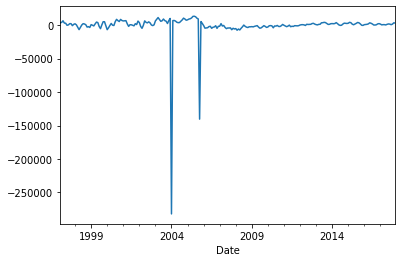

                             ARIMA Model Results                              
Dep. Variable:                D.32438   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2833.976
Method:                       css-mle   S.D. of innovations          20269.627
Date:                Sun, 22 Aug 2021   AIC                           5675.953
Time:                        17:55:47   BIC                           5690.039
Sample:                    03-31-1997   HQIC                          5681.622
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -425.6139    876.282     -0.486      0.628   -2143.095    1291.867
ar.L1.D.32438     0.8486      0.095      8.893      0.000       0.662       1.036
ma.L1.D.32438    -0.8981      0.076    -

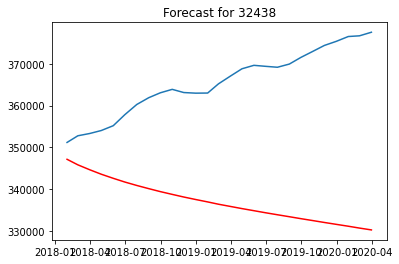

RSME: 30950.069409479005
Projected Return: -4.87%
-------------------------------------------------------------
Zipcode: 32444
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 32449
First difference
ADF Statistic: -3.004313
p-value: 0.034494


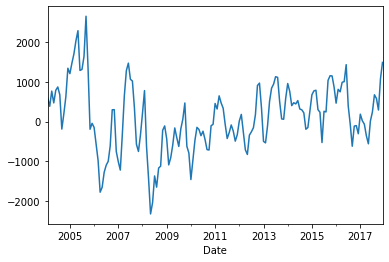

                             ARIMA Model Results                              
Dep. Variable:                D.32449   No. Observations:                  166
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1228.433
Method:                       css-mle   S.D. of innovations            391.007
Date:                Sun, 22 Aug 2021   AIC                           2470.867
Time:                        17:55:52   BIC                           2492.651
Sample:                    03-31-2004   HQIC                          2479.709
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           134.4189    173.160      0.776      0.439    -204.969     473.806
ar.L1.D.32449     0.2175      0.091      2.387      0.018       0.039       0.396
ar.L2.D.32449    -0.0121      0.102     

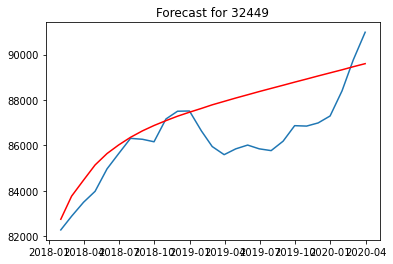

RSME: 1528.195016640439
Projected Return: 8.28%
-------------------------------------------------------------
Zipcode: 32456
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 32465
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 32466
First difference
ADF Statistic: -6.272502
p-value: 0.000000


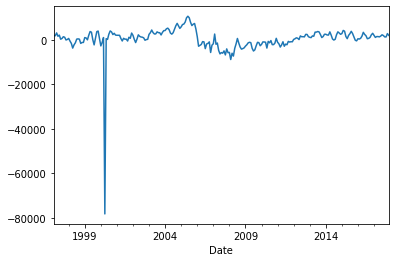

                             ARIMA Model Results                              
Dep. Variable:                D.32466   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2507.724
Method:                       css-mle   S.D. of innovations           5493.888
Date:                Sun, 22 Aug 2021   AIC                           5023.448
Time:                        17:55:56   BIC                           5037.534
Sample:                    03-31-1997   HQIC                          5029.117
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           532.5948    927.987      0.574      0.567   -1286.227    2351.416
ar.L1.D.32466     0.9182      0.054     17.100      0.000       0.813       1.023
ma.L1.D.32466    -0.7751      0.089     

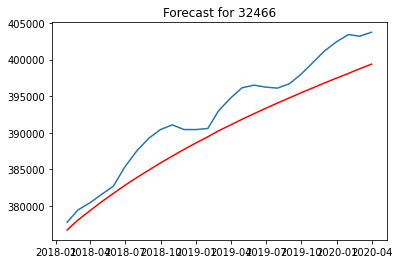

RSME: 3315.1141021988174
Projected Return: 6.01%
-------------------------------------------------------------
Zipcode: 92227
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 92231
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 92233
First difference
ADF Statistic: -14.183621
p-value: 0.000000


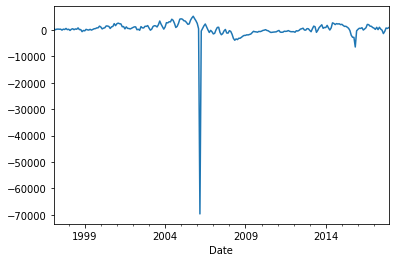

                             ARIMA Model Results                              
Dep. Variable:                D.92233   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2466.747
Method:                       css-mle   S.D. of innovations           4665.832
Date:                Sun, 22 Aug 2021   AIC                           4941.494
Time:                        17:55:59   BIC                           4955.580
Sample:                    03-31-1997   HQIC                          4947.163
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           208.3093    346.361      0.601      0.548    -470.547     887.165
ar.L1.D.92233     0.4214      0.450      0.936      0.350      -0.461       1.304
ma.L1.D.92233    -0.3202      0.470     

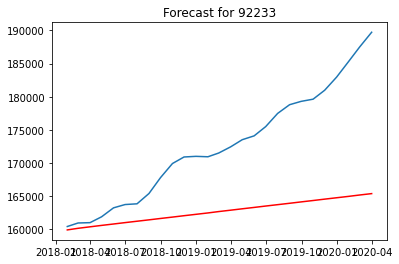

RSME: 12001.742908766022
Projected Return: 3.43%
-------------------------------------------------------------
Zipcode: 92243
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 92249
First difference
ADF Statistic: -8.576460
p-value: 0.000000


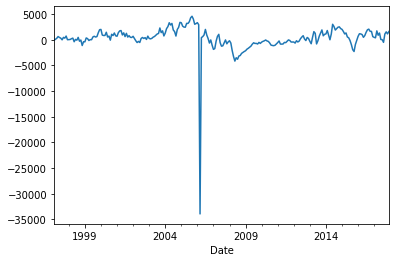

                             ARIMA Model Results                              
Dep. Variable:                D.92249   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2308.601
Method:                       css-mle   S.D. of innovations           2477.564
Date:                Sun, 22 Aug 2021   AIC                           4625.201
Time:                        17:56:03   BIC                           4639.287
Sample:                    03-31-1997   HQIC                          4630.870
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           340.5933    368.653      0.924      0.356    -381.953    1063.140
ar.L1.D.92249     0.9141      0.065     14.025      0.000       0.786       1.042
ma.L1.D.92249    -0.7927      0.102     

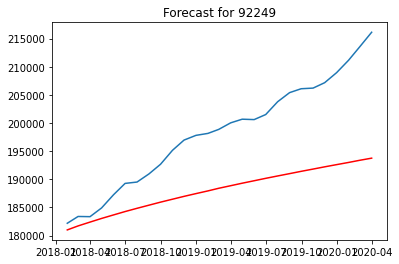

RSME: 11658.871905705524
Projected Return: 7.04%
-------------------------------------------------------------
Zipcode: 92250
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 92251
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 92273
First difference
ADF Statistic: -3.928254
p-value: 0.001836


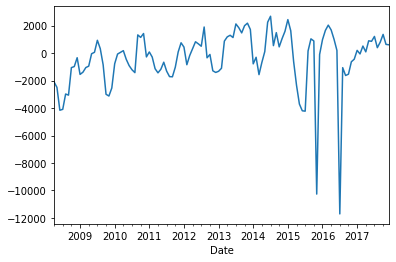

                             ARIMA Model Results                              
Dep. Variable:                D.92273   No. Observations:                  116
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1037.762
Method:                       css-mle   S.D. of innovations           1849.476
Date:                Sun, 22 Aug 2021   AIC                           2087.524
Time:                        17:56:08   BIC                           2104.046
Sample:                    05-31-2008   HQIC                          2094.231
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -375.9870    230.095     -1.634      0.105    -826.965      74.990
ar.L1.D.92273     1.0547      0.107      9.885      0.000       0.846       1.264
ar.L2.D.92273    -0.8034      0.092     

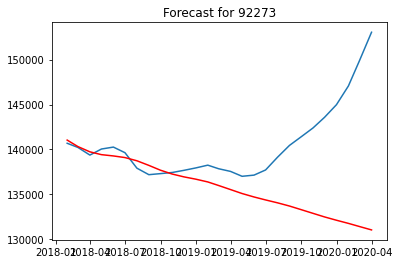

RSME: 7733.728130426988
Projected Return: -7.09%
-------------------------------------------------------------
Zipcode: 92274
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 92275
First difference
ADF Statistic: -6.508108
p-value: 0.000000


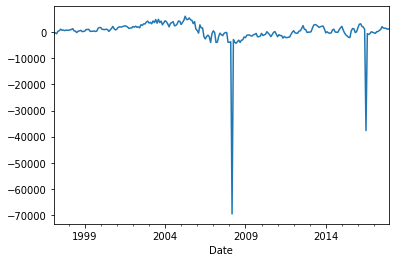

                             ARIMA Model Results                              
Dep. Variable:                D.92275   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2492.119
Method:                       css-mle   S.D. of innovations           5161.263
Date:                Sun, 22 Aug 2021   AIC                           4992.238
Time:                        17:56:11   BIC                           5006.324
Sample:                    03-31-1997   HQIC                          4997.907
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           351.2547    908.091      0.387      0.699   -1428.571    2131.080
ar.L1.D.92275     0.9433      0.038     24.905      0.000       0.869       1.018
ma.L1.D.92275    -0.8352      0.064    -

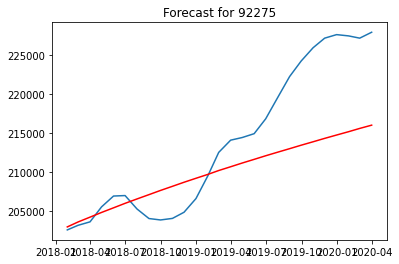

RSME: 6887.285616132225
Projected Return: 6.42%
-------------------------------------------------------------
Zipcode: 92281
First difference
ADF Statistic: -11.337437
p-value: 0.000000


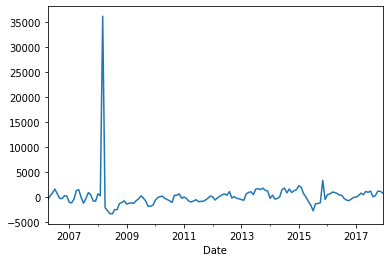

                             ARIMA Model Results                              
Dep. Variable:                D.92281   No. Observations:                  140
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1329.266
Method:                       css-mle   S.D. of innovations           3196.051
Date:                Sun, 22 Aug 2021   AIC                           2668.531
Time:                        17:56:12   BIC                           2683.239
Sample:                    05-31-2006   HQIC                          2674.508
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            99.1485     85.390      1.161      0.248     -68.212     266.509
ar.L1.D.92281     1.0035      0.084     11.931      0.000       0.839       1.168
ar.L2.D.92281    -0.0629      0.084     

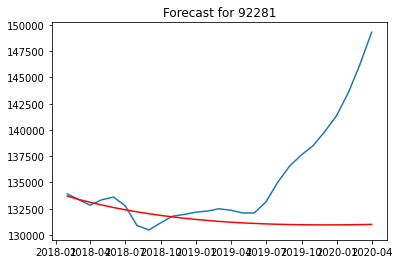

RSME: 6315.028078169511
Projected Return: -2.02%
-------------------------------------------------------------
Zipcode: 93201
First difference
ADF Statistic: -5.677121
p-value: 0.000001


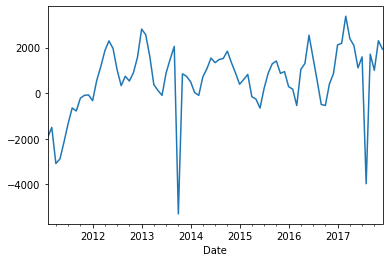

                             ARIMA Model Results                              
Dep. Variable:                D.93201   No. Observations:                   82
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -703.624
Method:                       css-mle   S.D. of innovations           1287.283
Date:                Sun, 22 Aug 2021   AIC                           1415.248
Time:                        17:56:17   BIC                           1424.875
Sample:                    03-31-2011   HQIC                          1419.113
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           606.5463    300.463      2.019      0.047      17.649    1195.444
ar.L1.D.93201     0.6614      0.172      3.855      0.000       0.325       0.998
ma.L1.D.93201    -0.2725      0.203     

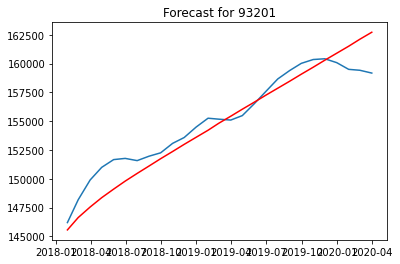

RSME: 1472.7842172167743
Projected Return: 11.78%
-------------------------------------------------------------
Zipcode: 93202
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93204
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93207
First difference
ADF Statistic: -8.355404
p-value: 0.000000


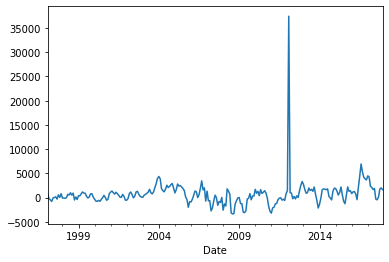

                             ARIMA Model Results                              
Dep. Variable:                D.93207   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2326.911
Method:                       css-mle   S.D. of innovations           2666.426
Date:                Sun, 22 Aug 2021   AIC                           4661.822
Time:                        17:56:21   BIC                           4675.908
Sample:                    03-31-1997   HQIC                          4667.491
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           730.9841    278.722      2.623      0.009     184.699    1277.269
ar.L1.D.93207     0.6552      0.168      3.907      0.000       0.327       0.984
ma.L1.D.93207    -0.4275      0.203     

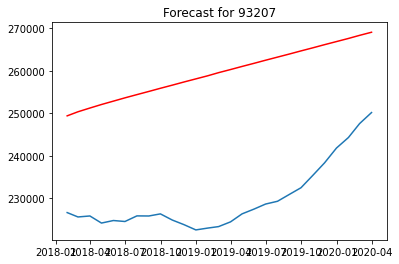

RSME: 30080.757706974724
Projected Return: 7.89%
-------------------------------------------------------------
Zipcode: 93212
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93218
First difference
ADF Statistic: -8.471675
p-value: 0.000000


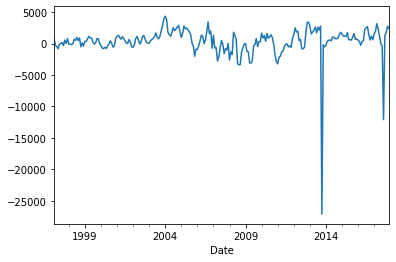

                             ARIMA Model Results                              
Dep. Variable:                D.93218   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2286.814
Method:                       css-mle   S.D. of innovations           2271.407
Date:                Sun, 22 Aug 2021   AIC                           4581.629
Time:                        17:56:25   BIC                           4595.715
Sample:                    03-31-1997   HQIC                          4587.298
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           382.2411    221.331      1.727      0.085     -51.559     816.041
ar.L1.D.93218     0.6098      0.171      3.570      0.000       0.275       0.945
ma.L1.D.93218    -0.3967      0.197     

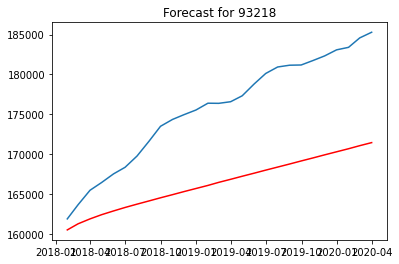

RSME: 9911.194670284656
Projected Return: 6.8%
-------------------------------------------------------------
Zipcode: 93219
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93221
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93223
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93227
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93230
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93235
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93239
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93244
First difference
ADF Statistic: -8.187340
p-value: 0.000000


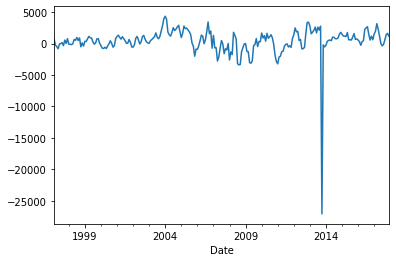

                             ARIMA Model Results                              
Dep. Variable:                D.93244   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2268.249
Method:                       css-mle   S.D. of innovations           2108.695
Date:                Sun, 22 Aug 2021   AIC                           4544.497
Time:                        17:56:30   BIC                           4558.583
Sample:                    03-31-1997   HQIC                          4550.167
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           412.5126    229.007      1.801      0.073     -36.333     861.358
ar.L1.D.93244     0.6935      0.143      4.836      0.000       0.412       0.975
ma.L1.D.93244    -0.4708      0.177     

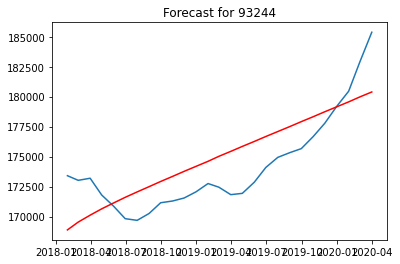

RSME: 2603.684864746389
Projected Return: 6.81%
-------------------------------------------------------------
Zipcode: 93245
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93247
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93256
First difference
ADF Statistic: -3.223460
p-value: 0.018666


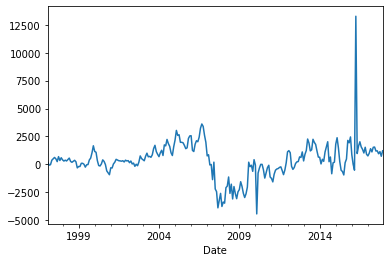

                             ARIMA Model Results                              
Dep. Variable:                D.93256   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2113.319
Method:                       css-mle   S.D. of innovations           1132.862
Date:                Sun, 22 Aug 2021   AIC                           4234.638
Time:                        17:56:34   BIC                           4248.724
Sample:                    03-31-1997   HQIC                          4240.308
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           403.9800    445.814      0.906      0.366    -469.799    1277.759
ar.L1.D.93256     0.9418      0.026     36.034      0.000       0.891       0.993
ma.L1.D.93256    -0.6176      0.064     

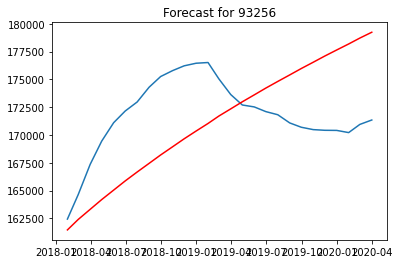

RSME: 5489.691478568591
Projected Return: 11.01%
-------------------------------------------------------------
Zipcode: 93257
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93261
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93265
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93266
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93267
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93270
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93271
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93272
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 93274
Se

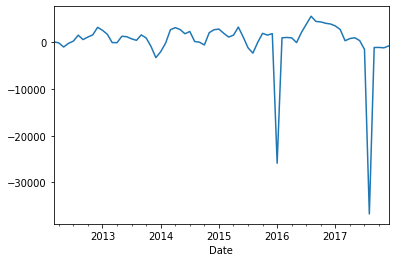

                             ARIMA Model Results                              
Dep. Variable:                D.93670   No. Observations:                   69
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -695.179
Method:                       css-mle   S.D. of innovations           5744.486
Date:                Sun, 22 Aug 2021   AIC                           1398.358
Time:                        17:56:37   BIC                           1407.294
Sample:                    04-30-2012   HQIC                          1401.903
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           198.8584    829.164      0.240      0.811   -1426.273    1823.990
ar.L1.D.93670     0.4877      0.686      0.711      0.480      -0.857       1.833
ma.L1.D.93670    -0.3834      0.724     

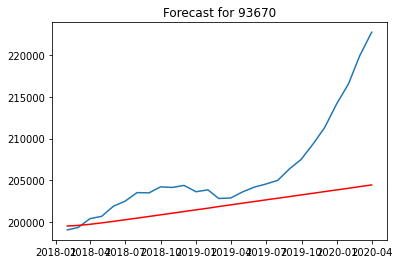

RSME: 6228.557532260373
Projected Return: 2.46%
-------------------------------------------------------------
Zipcode: 95914
First difference
ADF Statistic: -3.640605
p-value: 0.005031


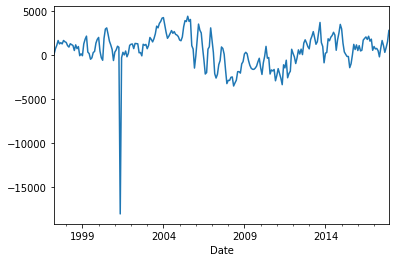

                             ARIMA Model Results                              
Dep. Variable:                D.95914   No. Observations:                  248
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2181.530
Method:                       css-mle   S.D. of innovations           1597.527
Date:                Sun, 22 Aug 2021   AIC                           4373.061
Time:                        17:56:40   BIC                           4390.628
Sample:                    05-31-1997   HQIC                          4380.133
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           621.7439    521.452      1.192      0.234    -400.283    1643.771
ar.L1.D.95914     1.2424      0.101     12.254      0.000       1.044       1.441
ar.L2.D.95914    -0.2771      0.087     

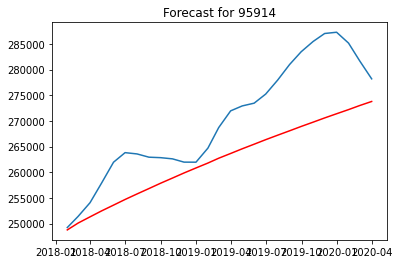

RSME: 9003.789965302769
Projected Return: 10.06%
-------------------------------------------------------------
Zipcode: 95916
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95917
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95926
First difference
ADF Statistic: -3.593426
p-value: 0.005888


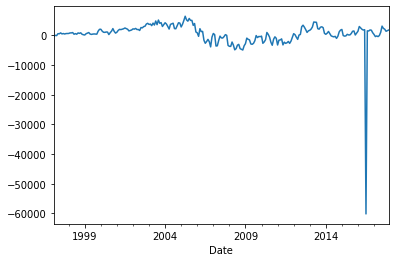

                             ARIMA Model Results                              
Dep. Variable:                D.95926   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2440.561
Method:                       css-mle   S.D. of innovations           4199.048
Date:                Sun, 22 Aug 2021   AIC                           4889.122
Time:                        17:56:43   BIC                           4903.208
Sample:                    03-31-1997   HQIC                          4894.791
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           524.0735    799.590      0.655      0.513   -1043.093    2091.240
ar.L1.D.95926     0.9530      0.030     31.305      0.000       0.893       1.013
ma.L1.D.95926    -0.8504      0.053    -

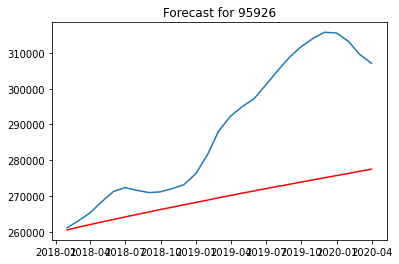

RSME: 23809.153757354758
Projected Return: 6.5%
-------------------------------------------------------------
Zipcode: 95928
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95930
First difference
ADF Statistic: -5.486410
p-value: 0.000002


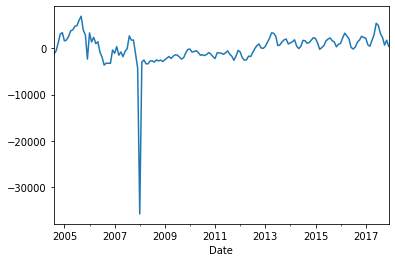

                             ARIMA Model Results                              
Dep. Variable:                D.95930   No. Observations:                  160
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1513.706
Method:                       css-mle   S.D. of innovations           3103.277
Date:                Sun, 22 Aug 2021   AIC                           3037.411
Time:                        17:56:49   BIC                           3052.787
Sample:                    09-30-2004   HQIC                          3043.655
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           324.6793   1000.254      0.325      0.746   -1635.782    2285.140
ar.L1.D.95930     1.1530      0.123      9.354      0.000       0.911       1.395
ar.L2.D.95930    -0.1919      0.101     

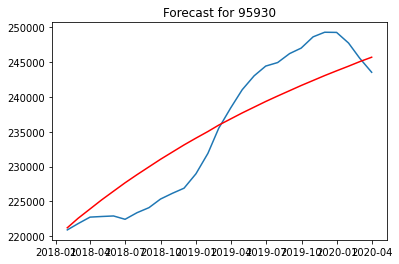

RSME: 4379.383266771111
Projected Return: 11.06%
-------------------------------------------------------------
Zipcode: 95938
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95941
First difference
ADF Statistic: -7.517789
p-value: 0.000000


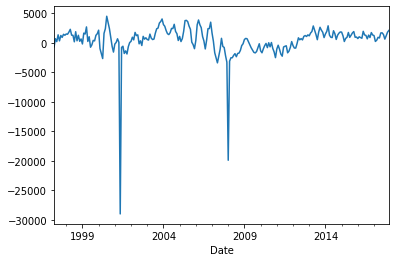

                             ARIMA Model Results                              
Dep. Variable:                D.95941   No. Observations:                  248
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2291.851
Method:                       css-mle   S.D. of innovations           2494.365
Date:                Sun, 22 Aug 2021   AIC                           4591.702
Time:                        17:56:53   BIC                           4605.756
Sample:                    05-31-1997   HQIC                          4597.359
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           432.8749    424.477      1.020      0.309    -399.085    1264.835
ar.L1.D.95941     0.8779      0.068     12.967      0.000       0.745       1.011
ma.L1.D.95941    -0.6665      0.111     

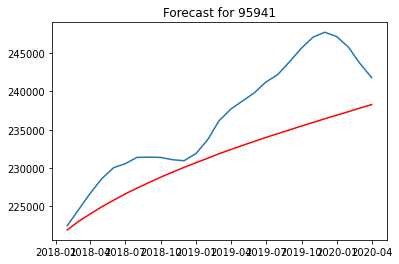

RSME: 6042.489898423637
Projected Return: 7.36%
-------------------------------------------------------------
Zipcode: 95942
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95948
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95954
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95958
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95965
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95966
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95968
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95969
First difference
ADF Statistic: -3.251370
p-value: 0.017197


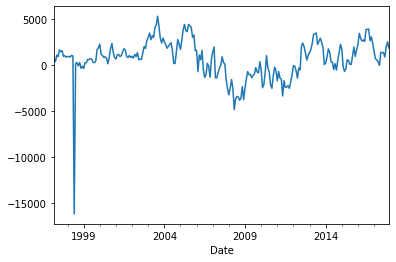

                             ARIMA Model Results                              
Dep. Variable:                D.95969   No. Observations:                  249
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2170.991
Method:                       css-mle   S.D. of innovations           1477.510
Date:                Sun, 22 Aug 2021   AIC                           4349.982
Time:                        17:56:57   BIC                           4364.052
Sample:                    04-30-1997   HQIC                          4355.645
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           737.5702    549.990      1.341      0.181    -340.390    1815.530
ar.L1.D.95969     0.9269      0.031     30.233      0.000       0.867       0.987
ma.L1.D.95969    -0.5519      0.073     

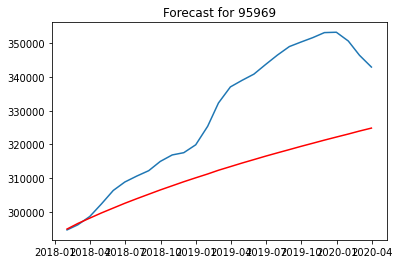

RSME: 20156.513482446986
Projected Return: 10.18%
-------------------------------------------------------------
Zipcode: 95972
Log
ADF Statistic: -4.727755
p-value: 0.000075


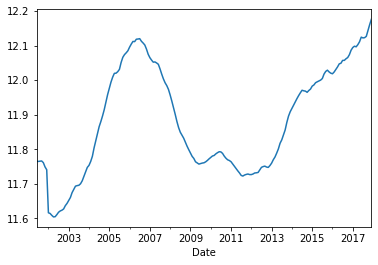

                             ARIMA Model Results                              
Dep. Variable:                  D.log   No. Observations:                  198
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 622.938
Method:                       css-mle   S.D. of innovations              0.010
Date:                Sun, 22 Aug 2021   AIC                          -1237.876
Time:                        17:57:01   BIC                          -1224.723
Sample:                    07-31-2001   HQIC                         -1232.552
                         - 12-31-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0023      0.003      0.724      0.470      -0.004       0.008
ar.L1.D.log     0.9148      0.044     20.768      0.000       0.828       1.001
ma.L1.D.log    -0.6210      0.089     -6.953    

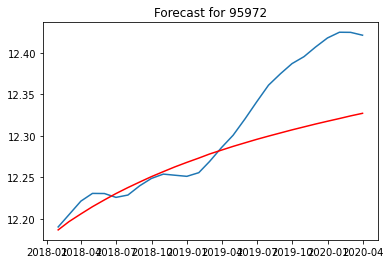

RSME: 0.05287959317213971
Projected Return: 1.15%
-------------------------------------------------------------
Zipcode: 95973
Series is not stable!
TypeError
-------------------------------------------------------------
Zipcode: 95974
First difference
ADF Statistic: -4.057000
p-value: 0.001140


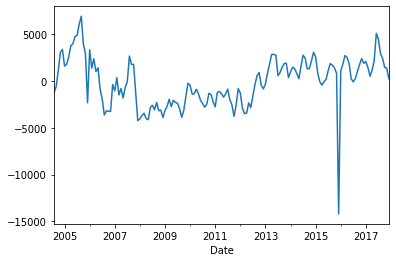

                             ARIMA Model Results                              
Dep. Variable:                D.95974   No. Observations:                  160
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1429.911
Method:                       css-mle   S.D. of innovations           1835.900
Date:                Sun, 22 Aug 2021   AIC                           2871.823
Time:                        17:57:04   BIC                           2890.274
Sample:                    09-30-2004   HQIC                          2879.315
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           122.9451    884.217      0.139      0.890   -1610.089    1855.979
ar.L1.D.95974     0.9455      0.042     22.587      0.000       0.863       1.028
ma.L1.D.95974    -0.4253      0.091     

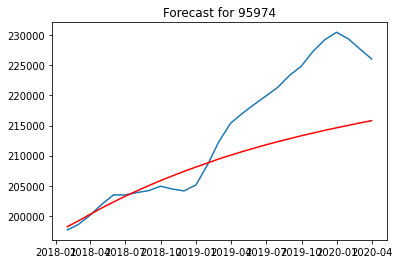

RSME: 7871.631161098549
Projected Return: 8.88%
-------------------------------------------------------------
Zipcode: 95978
First difference
ADF Statistic: -3.779377
p-value: 0.003126


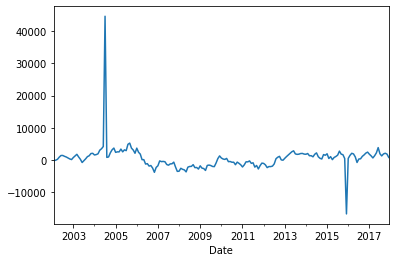

                             ARIMA Model Results                              
Dep. Variable:                D.95978   No. Observations:                  190
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1826.200
Method:                       css-mle   S.D. of innovations           3610.844
Date:                Sun, 22 Aug 2021   AIC                           3660.401
Time:                        17:57:09   BIC                           3673.389
Sample:                    03-31-2002   HQIC                          3665.662
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           587.2673    793.967      0.740      0.460    -968.880    2143.414
ar.L1.D.95978     0.9356      0.041     22.675      0.000       0.855       1.016
ma.L1.D.95978    -0.7948      0.070    -

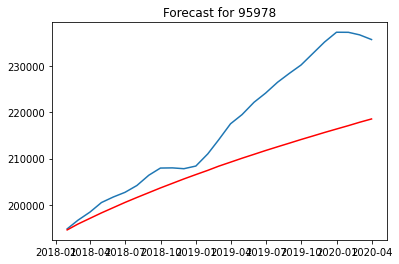

RSME: 11290.561533977905
Projected Return: 12.33%
-------------------------------------------------------------
Zipcode: 96092
First difference
ADF Statistic: -5.781071
p-value: 0.000001


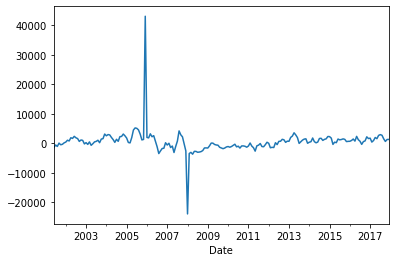

                             ARIMA Model Results                              
Dep. Variable:                D.96092   No. Observations:                  198
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1905.688
Method:                       css-mle   S.D. of innovations           3659.738
Date:                Sun, 22 Aug 2021   AIC                           3819.376
Time:                        17:57:14   BIC                           3832.529
Sample:                    07-31-2001   HQIC                          3824.700
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           510.3933    628.986      0.811      0.418    -722.397    1743.183
ar.L1.D.96092     0.8984      0.068     13.211      0.000       0.765       1.032
ma.L1.D.96092    -0.7471      0.105     

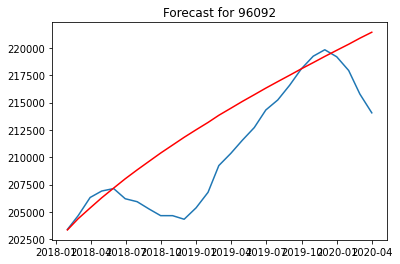

RSME: 3890.240487708653
Projected Return: 8.88%
   ZipCode          RSME  Return
0    32404  13421.758884   -0.28
1    32407      0.016902    0.95
2    32438  30950.069409   -4.87
3    32449   1528.195017    8.28
4    32466   3315.114102    6.01
5    92233  12001.742909    3.43
6    92249  11658.871906    7.04
7    92273   7733.728130   -7.09
8    92275   6887.285616    6.42
9    92281   6315.028078   -2.02
10   93201   1472.784217   11.78
11   93207  30080.757707    7.89
12   93218   9911.194670    6.80
13   93244   2603.684865    6.81
14   93256   5489.691479   11.01
15   93670   6228.557532    2.46
16   95914   9003.789965   10.06
17   95926  23809.153757    6.50
18   95930   4379.383267   11.06
19   95941   6042.489898    7.36
20   95969  20156.513482   10.18
21   95972      0.052880    1.15
22   95974   7871.631161    8.88
23   95978  11290.561534   12.33
24   96092   3890.240488    8.88


In [195]:
forecastedReturns = pd.DataFrame(columns=['ZipCode','RSME', 'Return'])
# model testing/fitting and return forecast
for zipcode in list(modelingdf.columns):
  if zipcode == '32461' or zipcode == '93258' or zipcode == '93603' or zipcode =='95925':
    pass
  else:
    print("-------------------------------------------------------------")

    try:
    
      print('Zipcode: '+ zipcode)
      try:
        model, testdf = Arima_modeling(modelingdf, zipcode)
        print(model.summary())
        #model verification and forecast
        rsme, returnval = Arima_forecast(model, testdf, zipcode)
        print("RSME: "+ str(rsme))
        print("Projected Return: " + str(returnval) + '%')
        # adding Selection criteria values to final analysis dataframe
        forecastedReturns = forecastedReturns.append({'ZipCode': zipcode,
                                                      'RSME':rsme,
                                                      'Return': returnval},
                                                      ignore_index=True) 
      except TypeError:
        print('TypeError')

    except ValueError:
      print('Zipcode: '+ zipcode)
      print('Series is not stable!')


In [198]:
#final Zip Code list
finalZipCodeList = forecastedReturns[forecastedReturns['Return'] > 10.00]
print(finalZipCodeList.sort_values(by='Return', ascending=False))


   ZipCode          RSME  Return
23   95978  11290.561534   12.33
10   93201   1472.784217   11.78
18   95930   4379.383267   11.06
14   93256   5489.691479   11.01
20   95969  20156.513482   10.18
16   95914   9003.789965   10.06
